<center> <font size='6' font-weight='bold'> Tripletloss Part </font> </center>  
<center> <i> Projet Navee</i> </center>
<center> <i> Matheus, Bruno and Tony </i> </center>  

# Preparations

In [1]:
import sys
import os

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize

from sklearn.metrics import roc_curve,roc_auc_score

Using TensorFlow backend.


## Change to main file tree level.

In [2]:
os.getcwd()

'/Users/Tony/Desktop/projet-navee/tripletloss'

In [3]:
os.chdir('..')

In [4]:
os.getcwd()

'/Users/Tony/Desktop/projet-navee'

## Imports

In [5]:
from data import *

In [6]:
from tripletloss import * # imports tripletloss.py
from data.data import * # imports data.py
from data.Data_Gen import * # imports Data_Gen.py

## Config verification

In [7]:
db_path = 'data/database_BAM.sqlite'

Checking if the database has been correctly imported.

In [8]:
assert os.path.exists(db_path), "Database not found 👎🏻\n\
    Please check that you've successfully copied the database in the data\
    directory after having cloned the project ‼️"
print ('Dataset found 🤙🏻')

Dataset found 🤙🏻


# Examples and tests

## Creating a DataGenerator object

In [9]:
db = data_base(db_path)

`db` is a custom object defined in `data.py`

In [10]:
print(dir(db))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'classes', 'classes_emotions', 'classes_labels', 'classes_labels_emotions', 'classes_labels_media', 'classes_media', 'file_path', 'get_image', 'get_images', 'get_images_', 'get_images_emotions', 'get_images_labels', 'get_images_media', 'get_label', 'get_label_emotions', 'get_label_labels', 'get_label_media', 'mids', 'return_classes', 'train_test_split']


In [11]:
image_size = (224,224) # resize parameter

In [12]:
def preprocess(x):
    x = x.convert('RGB')
    x = x.resize(image_size)
    x = np.array(x)
    x = x / 255.
    return x

In [13]:
list(db.classes.values())

['content_building',
 'emotion_happy',
 'content_flower',
 'content_bicycle',
 'media_comic',
 'content_people',
 'media_3d_graphics',
 'content_dog',
 'media_vectorart',
 'emotion_scary',
 'emotion_gloomy',
 'media_graphite',
 'emotion_peaceful',
 'media_pen_ink',
 'content_cars',
 'media_oilpaint',
 'content_cat',
 'content_tree',
 'content_bird',
 'media_watercolor']

In [14]:
classes_list = list(db.classes.values())

## Getting a subset of the data

In [15]:
nb_images = 500 # number of images to extract from the database

In [16]:
IDs = db.get_images(nb_images)

In [17]:
labels = {i:db.get_label(i) for i in IDs}

`labels` have the shape:  
{4288:
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...}

In [18]:
len(IDs)

2020

## Splitting train/test sets

In [19]:
train_ratio = 0.7

partition = {}

partition['train'] = IDs[:int(train_ratio * len(IDs))]
partition['test'] = IDs[int(train_ratio*len(IDs)):len(IDs)]

## Creating data_generators

In [20]:
batch_size = 32

In [21]:
train_generator = DataGenerator(partition['train'], classes_list, db=db, batch_size=batch_size, pre=preprocess)
validation_generator = DataGenerator(partition['test'], classes_list, db=db, batch_size=batch_size, pre=preprocess)

In [22]:
train_generator.batch_size

32

In [23]:
dir(train_generator)

['_DataGenerator__data_generation',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'batch_size',
 'db',
 'dim',
 'indexes',
 'list_IDs',
 'lista',
 'load_image',
 'n_channels',
 'n_classes',
 'on_epoch_end',
 'pre',
 'shuffle',
 'use_sequence_api']

`train_generator` est un tenseur tel que :

- La première dimension donne le nombre d'éléments dans un batch.
- La deuxième dimension a une dimension de 2, le premier axe donne les batchs tandis que le 2ème axe donne la liste des classes.
- La troisième dimension donne les éléments du batch.

## Visualisation

**‼️IMPORTANT: ‼️**  
Calling `train_generator[0][0][0]` downloads a full batch of images. Thus we'll be careful never to call `train_generator[0][0][0]` but to instead set `current_batch = train_generator[0][0]` and then to browse through `current_batch`.

Here, it's okay since we only display one image, but there are risks that a naive loop gives a complexity in O(n!) instead of O(n) ☠️.

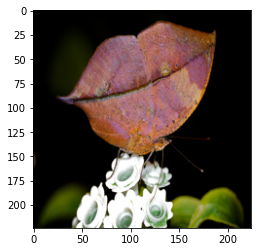

In [24]:
plt.imshow(train_generator[0][0][0])

## Getting class number

In [25]:
np.argmax(train_generator[0][1][0])

2

# TripletLoss

## Utilities

In [26]:
def DrawPics(data_generator, nb=0, template='{}', batch_nb=0):
    if (nb==0):
        N = data_generator.batch_size
    else:
        N = min(nb, data_generator.batch_size)
        
    fig=plt.figure(figsize=(16,2))
    
    nbligne = floor(N/20)+1
    current_batch = data_generator[batch_nb]
    current_batch_x = current_batch[0]
    current_batch_y = current_batch[1]
    
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(current_batch_x[m],vmin=0, vmax=1,cmap='Greys')
        
        class_nb = np.argmax(current_batch_y[m])
        subplot.title.set_text((template.format(str(class_nb))))
    return

In [27]:
nb_classes = train_generator.n_classes
img_rows, img_cols = train_generator.dim
input_shape = (img_rows, img_cols, 1)

CPU times: user 2.59 s, sys: 196 ms, total: 2.78 s
Wall time: 5.3 s


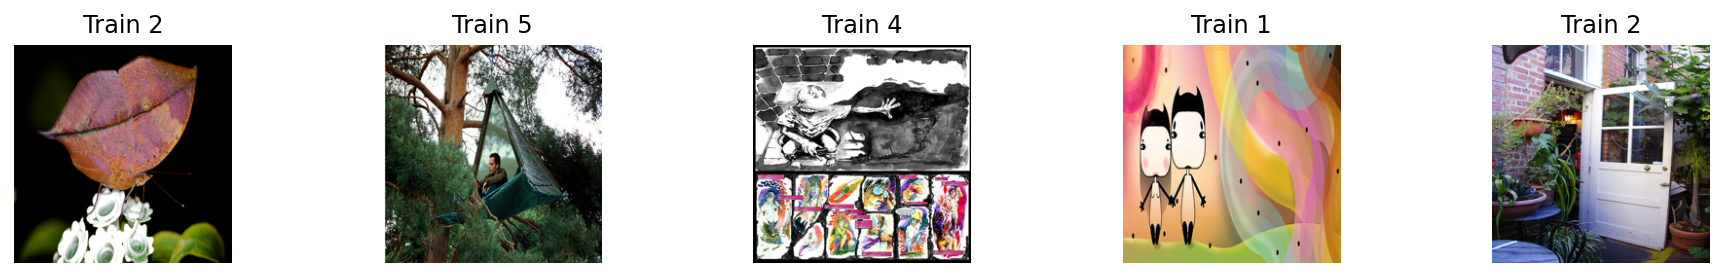

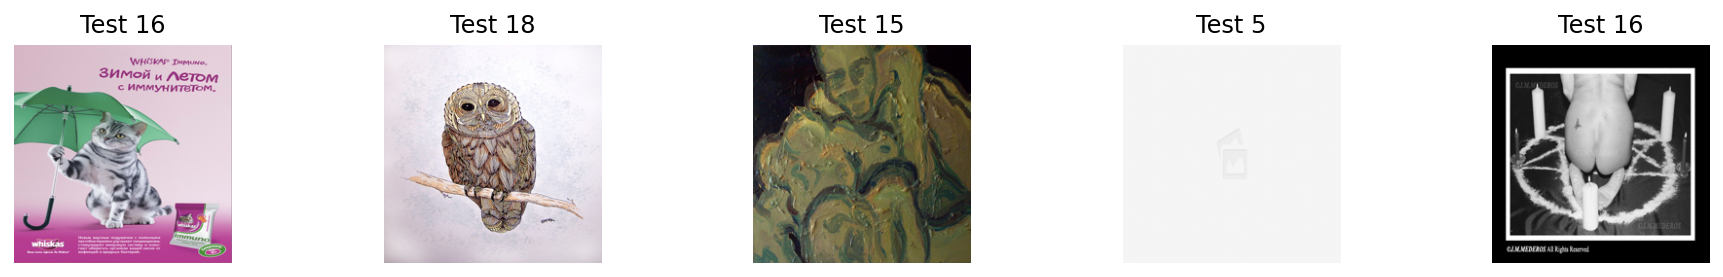

In [30]:
%%time
DrawPics(train_generator, nb=5, template='Train {}', batch_nb=0)
DrawPics(validation_generator, nb=5, template='Test {}', batch_nb=0)

In [ ]:
def buildDataSet(data_generator):
    """Build dataset (numpy array) for faster and easier data manipulation.
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """
    
    # STEP 1: Removing the batch structure and separating images from labels.
    x_train = []
    y_train = []
    for batch_nb in range(len(data_generator)):
        current_batch = data_generator[batch_nb]

        for idx in range(len(current_batch)):
            x_train.append(current_batch[0][idx])
            y_train.append(np.argmax(current_batch[1][idx]))
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
   
    
    #Sorting images by classes
    nb_classes = data_generator.n_classes
    img_rows, img_cols = data_generator.dim
    
    x_train_sorted = []
    for n in range(nb_classes):
        x_train_sorted.append(np.asarray([img for idx, img in enumerate(x_train) if y_train[idx]==n]))
    
    return x_train, y_train, x_train_sorted

In [ ]:
%%timeit
x_train, y_train, x_train_sorted = buildDataSet(train_generator)

In [ ]:
print(f'x_train.shape = {x_train.shape}, should be ({nb_images}, {img_rows}, {img_cols}, 3)')
print(f'y_train.shape = {y_train.shape}, should be ({nb_images},)')
print(f'x_train_sorted.shape = {len(x_train_sorted)}, should be {train_generator.n_classes}')

## Build Neural Network for computing triplet similarity

In [ ]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

### Preparing batch for training

In [ ]:
def has_all_classes(X):
    ''' Return True if all classes are represented in X.'''
    nb_classes = len(X)
    l_isNull = [X[class_idx].shape[0]==0 for class_idx in range(nb_classes)]
    return not(any(l_isNull))

In [ ]:
has_all_classes(x_train_sorted)

In [ ]:
def get_batch_random(X, batch_size):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    x_train -- x_train generated from BuildDataSet 

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    
    
    nb_classes = len(X)
    
    m, w, h, c = X[0].shape
    
    assert has_all_classes(X), 'Not all classes are represented in X!'
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

In [ ]:
get_batch_random(X=x_train_sorted, batch_size=1)

In [ ]:
x_train_sorted.shape

In [ ]:
def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])